Using device: cuda


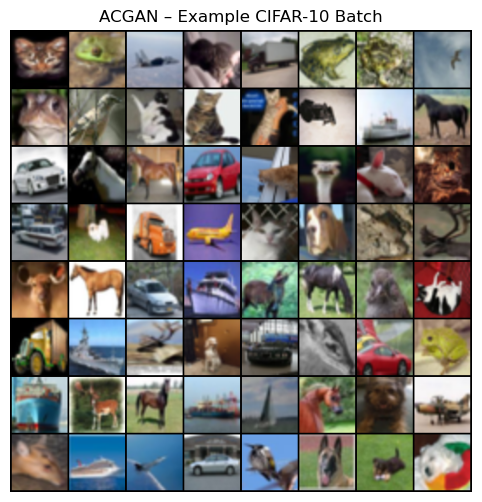

In [1]:
import os
from dataclasses import dataclass
from typing import List, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from torchvision.models.inception import inception_v3, Inception_V3_Weights
from scipy import linalg
import matplotlib.pyplot as plt

%matplotlib inline
torch.backends.cudnn.benchmark = True


@dataclass
class ACGANConfig:
    epochs: int = 50
    batch_size: int = 128
    z_dim: int = 100
    g_channels: int = 64
    d_channels: int = 64
    num_classes: int = 10
    lr: float = 2e-4
    beta1: float = 0.5
    beta2: float = 0.999
    image_size: int = 64
    channels: int = 3
    fid_samples: int = 2048  # samples for FID
    class_loss_weight: float = 1.0  # weight for class loss


cfg = ACGANConfig()


def set_seed(seed: int = 42) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

RESULTS_DIR = "ACGAN_results"
os.makedirs(os.path.join(RESULTS_DIR, "GeneratedImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "RealImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "Metrics"), exist_ok=True)

# CIFAR-10 pipeline (same as DCGAN/WGAN)
transform = transforms.Compose([
    transforms.Resize((cfg.image_size, cfg.image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])

train_set = datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=transform,
)

train_loader = DataLoader(
    train_set,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
)

# sanity check batch
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 6))
plt.axis("off")
plt.title("ACGAN – Example CIFAR-10 Batch")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu().numpy(),
        (1, 2, 0),
    )
)
plt.show()


In [2]:
class ACGANGenerator(nn.Module):
    """
    Conditional DCGAN-style generator for ACGAN.
    Takes noise z and class label y, outputs 64x64 RGB images.
    """
    def __init__(self, z_dim: int, base_ch: int, img_ch: int, num_classes: int, emb_dim: int = 100):
        super().__init__()
        self.z_dim = z_dim
        self.emb = nn.Embedding(num_classes, emb_dim)

        in_dim = z_dim + emb_dim

        self.net = nn.Sequential(
            self._block(in_dim, base_ch * 8, 4, 1, 0),   # 4x4
            self._block(base_ch * 8, base_ch * 4, 4, 2, 1),  # 8x8
            self._block(base_ch * 4, base_ch * 2, 4, 2, 1),  # 16x16
            self._block(base_ch * 2, base_ch, 4, 2, 1),      # 32x32
            nn.ConvTranspose2d(base_ch, img_ch, 4, 2, 1, bias=False),  # 64x64
            nn.Tanh(),
        )

    @staticmethod
    def _block(in_ch: int, out_ch: int, k: int, s: int, p: int) -> nn.Sequential:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, k, s, p, bias=False),
            nn.BatchNorm2d(out_ch, momentum=0.9),
            nn.ReLU(True),
        )

    def forward(self, z: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        # z: [B, z_dim, 1, 1], labels: [B]
        emb = self.emb(labels)                         # [B, emb_dim]
        emb = emb.view(emb.size(0), -1, 1, 1)          # [B, emb_dim, 1,1]
        z_cat = torch.cat([z, emb], dim=1)             # [B, z_dim+emb_dim,1,1]
        return self.net(z_cat)


class ACGANDiscriminator(nn.Module):
    """
    DCGAN-style discriminator with two heads:
      - source head: real/fake (sigmoid)
      - class head: CIFAR-10 class logits (no softmax)
    """
    def __init__(self, img_ch: int, base_ch: int, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(img_ch, base_ch, 4, 2, 1, bias=False),   # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_ch, base_ch * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(base_ch * 2, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_ch * 2, base_ch * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(base_ch * 4, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_ch * 4, base_ch * 8, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(base_ch * 8, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.flatten = nn.Flatten()

        feat_dim = base_ch * 8 * 4 * 4

        # source (real/fake) head
        self.source_head = nn.Sequential(
            nn.Linear(feat_dim, 1),
            nn.Sigmoid(),
        )

        # class head
        self.class_head = nn.Linear(feat_dim, num_classes)

    def forward(self, x: torch.Tensor):
        feat = self.features(x)
        feat = self.flatten(feat)
        source_out = self.source_head(feat).view(-1)     # real/fake prob
        class_logits = self.class_head(feat)             # class logits
        return source_out, class_logits


In [3]:
def init_acgan_weights(m: nn.Module) -> None:
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d, nn.Linear)):
        if hasattr(m, "weight") and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.zeros_(m.bias.data)


class FIDEvaluator(nn.Module):
    def __init__(self, device: torch.device):
        super().__init__()
        weights = Inception_V3_Weights.IMAGENET1K_V1
        inception = inception_v3(weights=weights, transform_input=False)
        inception.fc = nn.Identity()
        self.inception = inception.to(device).eval()
        for p in self.inception.parameters():
            p.requires_grad_(False)
        self.device = device

    @torch.no_grad()
    def _features(self, imgs: torch.Tensor) -> np.ndarray:
        imgs = (imgs + 1) / 2
        imgs = F.interpolate(imgs, size=(299, 299),
                             mode="bilinear", align_corners=False)
        out = self.inception(imgs.to(self.device))
        if isinstance(out, tuple):
            out = out[0]
        return out.cpu().numpy()

    def _stats(self, feats: np.ndarray):
        mu = np.mean(feats, axis=0)
        sigma = np.cov(feats, rowvar=False)
        return mu, sigma

    def forward(self, real: torch.Tensor, fake: torch.Tensor) -> float:
        real_f = self._features(real)
        fake_f = self._features(fake)
        mu1, sigma1 = self._stats(real_f)
        mu2, sigma2 = self._stats(fake_f)

        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            eps = 1e-6
            covmean = linalg.sqrtm(
                (sigma1 + np.eye(sigma1.shape[0]) * eps).dot(
                    sigma2 + np.eye(sigma2.shape[0]) * eps
                )
            )
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = np.sum((mu1 - mu2) ** 2) + np.trace(
            sigma1 + sigma2 - 2 * covmean
        )
        return float(fid)


def discriminator_source_accuracy(source_real: torch.Tensor,
                                  source_fake: torch.Tensor) -> float:
    """
    Heuristic real/fake accuracy based on source head outputs.
    """
    real_pred = (source_real >= 0.5).float()
    fake_pred = (source_fake < 0.5).float()
    correct = real_pred.sum() + fake_pred.sum()
    total = source_real.numel() + source_fake.numel()
    return (correct / total).item() * 100.0


def discriminator_class_accuracy(class_logits: torch.Tensor,
                                 labels: torch.Tensor) -> float:
    preds = class_logits.argmax(dim=1)
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return 100.0 * correct / max(1, total)


def save_image_grid(tensor: torch.Tensor, path: str, title: str = "") -> None:
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    if title:
        plt.title(title)
    grid = vutils.make_grid(tensor, padding=2, normalize=True)
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.savefig(path, bbox_inches="tight")
    plt.close()


def plot_acgan_training(history: Dict[str, List[float]]) -> None:
    epochs = history["epoch_ids"]

    plt.figure(figsize=(18, 5))

    # Losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["gen_losses"], label="Generator Loss")
    plt.plot(epochs, history["disc_losses"], label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("ACGAN Losses")
    plt.legend()

    # Accuracies
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["disc_source_acc"], label="Disc Source Acc")
    plt.plot(epochs, history["disc_class_acc"], label="Disc Class Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("ACGAN Discriminator Accuracies")
    plt.legend()

    # FID
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["fid_scores"], label="FID Score")
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("ACGAN FID Progress")
    plt.legend()

    plt.tight_layout()
    out_path = os.path.join(RESULTS_DIR, "Metrics", "acgan_training_curves.png")
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print(f"Saved ACGAN training curves to {out_path}")


# Instantiate models
G = ACGANGenerator(cfg.z_dim, cfg.g_channels, cfg.channels,
                   cfg.num_classes).to(device)
D = ACGANDiscriminator(cfg.channels, cfg.d_channels,
                       cfg.num_classes).to(device)
G.apply(init_acgan_weights)
D.apply(init_acgan_weights)

print(G)
print(D)

# Losses and optimizers
bce = nn.BCELoss()
ce = nn.CrossEntropyLoss()

opt_G = optim.Adam(G.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))
opt_D = optim.Adam(D.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

fid_eval = FIDEvaluator(device)
fixed_noise = torch.randn(64, cfg.z_dim, 1, 1, device=device)
fixed_labels = torch.randint(0, cfg.num_classes, (64,), device=device)


ACGANGenerator(
  (emb): Embedding(10, 100)
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats

In [4]:
epoch_ids: List[int] = []
gen_losses: List[float] = []
disc_losses: List[float] = []
disc_source_acc_list: List[float] = []
disc_class_acc_list: List[float] = []
fid_scores: List[float] = []

best_fid = float("inf")
best_epoch = -1
best_G_state = None

print("Starting ACGAN training...")
for epoch in range(cfg.epochs):
    G.train()
    D.train()

    running_g = 0.0
    running_d = 0.0
    running_source_acc = 0.0
    running_class_acc = 0.0

    real_for_fid = []
    fake_for_fid = []

    num_batches = len(train_loader)

    for batch_idx, (real_imgs, labels) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        bsz = real_imgs.size(0)

        # ------------------ Train Discriminator ------------------
        D.zero_grad(set_to_none=True)

        real_source_labels = torch.full((bsz,), 1.0, device=device)
        fake_source_labels = torch.full((bsz,), 0.0, device=device)

        # Real images
        real_source_out, real_class_logits = D(real_imgs)
        d_real_source_loss = bce(real_source_out, real_source_labels)
        d_real_class_loss = ce(real_class_logits, labels)

        # Fake images
        noise = torch.randn(bsz, cfg.z_dim, 1, 1, device=device)
        fake_labels = torch.randint(0, cfg.num_classes, (bsz,), device=device)
        fake_imgs = G(noise, fake_labels)

        fake_source_out, fake_class_logits = D(fake_imgs.detach())
        d_fake_source_loss = bce(fake_source_out, fake_source_labels)
        # optionally no class loss on fake for D; keep real only for stability

        d_source_loss = d_real_source_loss + d_fake_source_loss
        d_class_loss = d_real_class_loss

        d_total_loss = d_source_loss + cfg.class_loss_weight * d_class_loss
        d_total_loss.backward()
        opt_D.step()

        # Discriminator accuracies
        batch_source_acc = discriminator_source_accuracy(real_source_out.detach(),
                                                         fake_source_out.detach())
        batch_class_acc = discriminator_class_accuracy(real_class_logits.detach(),
                                                       labels.detach())
        running_source_acc += batch_source_acc
        running_class_acc += batch_class_acc

        # ------------------ Train Generator ------------------
        G.zero_grad(set_to_none=True)
        noise = torch.randn(bsz, cfg.z_dim, 1, 1, device=device)
        gen_labels = torch.randint(0, cfg.num_classes, (bsz,), device=device)
        gen_imgs = G(noise, gen_labels)

        gen_source_out, gen_class_logits = D(gen_imgs)
        g_source_loss = bce(gen_source_out, real_source_labels)  # want D(fake)=1
        g_class_loss = ce(gen_class_logits, gen_labels)

        g_total_loss = g_source_loss + cfg.class_loss_weight * g_class_loss
        g_total_loss.backward()
        opt_G.step()

        running_g += g_total_loss.item()
        running_d += d_total_loss.item()

        # Collect for FID
        if batch_idx < 5:
            real_for_fid.append(real_imgs.detach())
            fake_for_fid.append(gen_imgs.detach())

    avg_g = running_g / num_batches
    avg_d = running_d / num_batches
    avg_source_acc = running_source_acc / num_batches
    avg_class_acc = running_class_acc / num_batches

    # FID
    with torch.no_grad():
        real_pool = torch.cat(real_for_fid, dim=0)[: cfg.fid_samples]
        fake_pool = torch.cat(fake_for_fid, dim=0)[: cfg.fid_samples]
        fid_val = fid_eval(real_pool, fake_pool)

    epoch_ids.append(epoch + 1)
    gen_losses.append(avg_g)
    disc_losses.append(avg_d)
    disc_source_acc_list.append(avg_source_acc)
    disc_class_acc_list.append(avg_class_acc)
    fid_scores.append(fid_val)

    if fid_val < best_fid:
        best_fid = fid_val
        best_epoch = epoch + 1
        best_G_state = G.state_dict()

    print(
        f"Epoch [{epoch+1}/{cfg.epochs}]  "
        f"D_loss: {avg_d:.4f}  G_loss: {avg_g:.4f}  "
        f"SrcAcc: {avg_source_acc:5.2f}%  ClsAcc: {avg_class_acc:5.2f}%  "
        f"FID: {fid_val:.2f}"
    )

    # Save generated samples every few epochs (like DCGAN/WGAN)
    if (epoch + 1) % 5 == 0 or (epoch + 1) == cfg.epochs:
        G.eval()
        with torch.no_grad():
            # use fixed noise + fixed labels for visual consistency
            fake_fixed = G(fixed_noise, fixed_labels).cpu()
        save_image_grid(
            fake_fixed,
            os.path.join(
                RESULTS_DIR,
                "GeneratedImages",
                f"acgan_epoch_{epoch+1:03d}.png",
            ),
            title=f"ACGAN Generated Images at Epoch {epoch+1}",
        )

print("ACGAN training finished.")
print(f"Best FID {best_fid:.2f} at epoch {best_epoch}")

# Load best generator
if best_G_state is not None:
    G.load_state_dict(best_G_state)

G_trained = G  # keep ref

# Save best fixed grid
with torch.no_grad():
    best_fake_fixed = G_trained(fixed_noise, fixed_labels).cpu()

save_image_grid(
    best_fake_fixed,
    os.path.join(
        RESULTS_DIR,
        "GeneratedImages",
        f"acgan_best_epoch_{best_epoch:03d}.png",
    ),
    title=f"ACGAN Best Epoch {best_epoch} (FID={best_fid:.2f})",
)

# History dict for plotting
acgan_history: Dict[str, List[float]] = {
    "epoch_ids": epoch_ids,
    "gen_losses": gen_losses,
    "disc_losses": disc_losses,
    "disc_source_acc": disc_source_acc_list,
    "disc_class_acc": disc_class_acc_list,
    "fid_scores": fid_scores,
}


Starting ACGAN training...
Epoch [1/50]  D_loss: 2.0819  G_loss: 4.0120  SrcAcc: 92.79%  ClsAcc: 44.05%  FID: 438.18
Epoch [2/50]  D_loss: 2.2077  G_loss: 2.2005  SrcAcc: 81.19%  ClsAcc: 54.49%  FID: 233.04
Epoch [3/50]  D_loss: 2.1453  G_loss: 2.3175  SrcAcc: 80.41%  ClsAcc: 57.11%  FID: 240.37
Epoch [4/50]  D_loss: 1.9975  G_loss: 2.4042  SrcAcc: 83.13%  ClsAcc: 59.85%  FID: 242.25
Epoch [5/50]  D_loss: 1.8284  G_loss: 2.6453  SrcAcc: 85.53%  ClsAcc: 62.38%  FID: 235.93
Epoch [6/50]  D_loss: 1.6812  G_loss: 2.7996  SrcAcc: 87.87%  ClsAcc: 64.56%  FID: 211.78
Epoch [7/50]  D_loss: 1.5132  G_loss: 3.0071  SrcAcc: 91.14%  ClsAcc: 65.73%  FID: 203.02
Epoch [8/50]  D_loss: 1.3461  G_loss: 3.3344  SrcAcc: 93.32%  ClsAcc: 67.97%  FID: 206.68
Epoch [9/50]  D_loss: 1.6451  G_loss: 2.9577  SrcAcc: 83.85%  ClsAcc: 68.40%  FID: 198.80
Epoch [10/50]  D_loss: 1.5267  G_loss: 3.0970  SrcAcc: 88.08%  ClsAcc: 69.77%  FID: 184.27
Epoch [11/50]  D_loss: 1.4059  G_loss: 3.2330  SrcAcc: 90.78%  ClsAcc: 7

Final ACGAN Metrics (best FID epoch):
Best Epoch: 14
Generator Loss: 4.0292
Discriminator Loss: 1.1280
Discriminator Source Accuracy: 94.75%
Discriminator Class Accuracy: 74.40%
Quality Score (FID): 162.5348


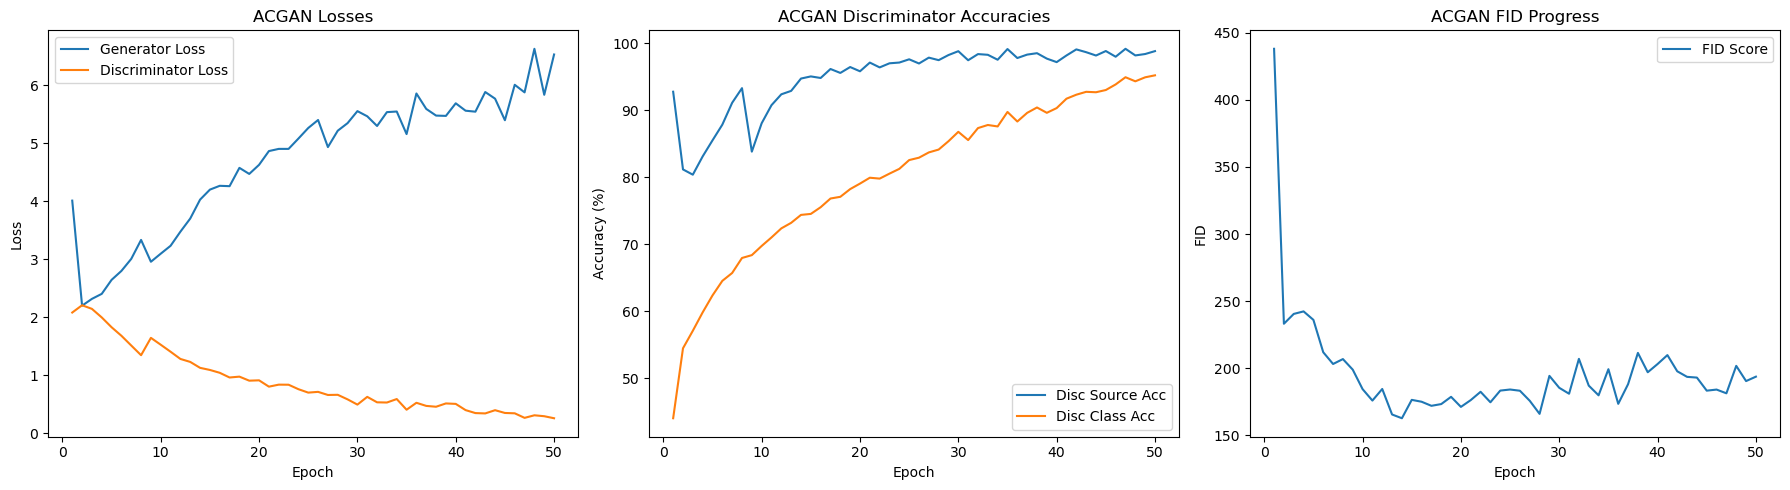

Saved ACGAN training curves to ACGAN_results/Metrics/acgan_training_curves.png


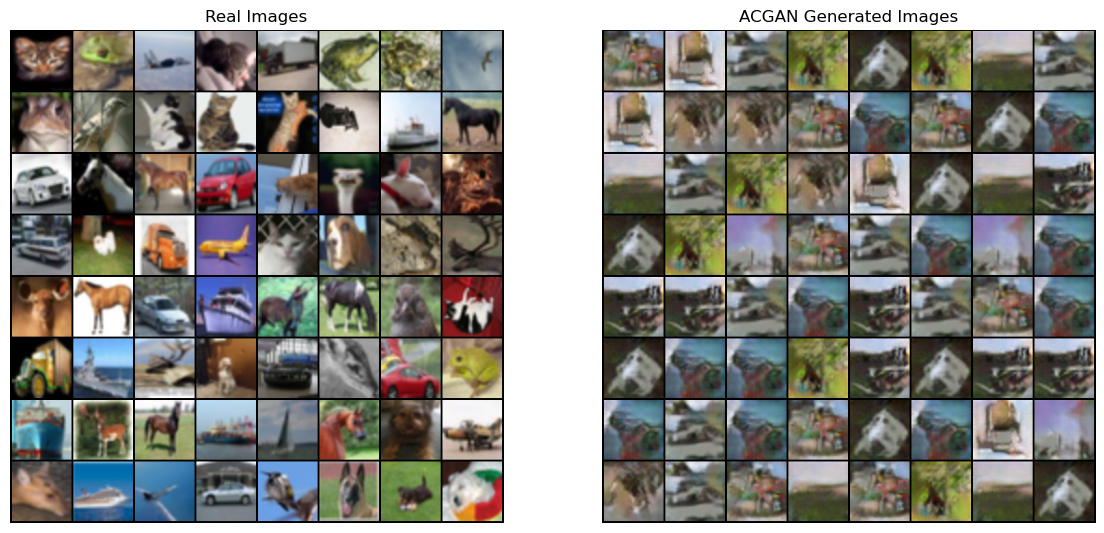


Saved ACGAN results in ACGAN_results directory


In [5]:
# ====== Final ACGAN Metrics, Plots, Grids ======
import numpy as np

# best index from recorded FID scores
best_idx = int(np.argmin(acgan_history["fid_scores"]))
best_epoch_acgan = acgan_history["epoch_ids"][best_idx]

final_gen_loss = acgan_history["gen_losses"][best_idx]
final_disc_loss = acgan_history["disc_losses"][best_idx]
final_disc_src_acc = acgan_history["disc_source_acc"][best_idx]
final_disc_cls_acc = acgan_history["disc_class_acc"][best_idx]
final_fid = acgan_history["fid_scores"][best_idx]

print("Final ACGAN Metrics (best FID epoch):")
print(f"Best Epoch: {best_epoch_acgan}")
print(f"Generator Loss: {final_gen_loss:.4f}")
print(f"Discriminator Loss: {final_disc_loss:.4f}")
print(f"Discriminator Source Accuracy: {final_disc_src_acc:.2f}%")
print(f"Discriminator Class Accuracy: {final_disc_cls_acc:.2f}%")
print(f"Quality Score (FID): {final_fid:.4f}")

# 1) Training curves
plot_acgan_training(acgan_history)

# 2) Final real vs generated grids (use same real_batch as at the top)
real_imgs = real_batch[0][:64].to(device)

G_trained.eval()
with torch.no_grad():
    fake_imgs = G_trained(fixed_noise, fixed_labels).cpu()

# Save grids
save_image_grid(
    real_imgs.cpu(),
    os.path.join(RESULTS_DIR, "RealImages", "acgan_real_grid.png"),
    title="Real Images"
)
save_image_grid(
    fake_imgs,
    os.path.join(RESULTS_DIR, "GeneratedImages", "acgan_fake_grid_final.png"),
    title="ACGAN Generated Images"
)

# Side-by-side figure (like DCGAN/WGAN)
real_grid = vutils.make_grid(real_imgs.cpu(), padding=2, normalize=True)
fake_grid = vutils.make_grid(fake_imgs, padding=2, normalize=True)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title("Real Images")
plt.axis("off")
plt.imshow(np.transpose(real_grid.numpy(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("ACGAN Generated Images")
plt.axis("off")
plt.imshow(np.transpose(fake_grid.numpy(), (1, 2, 0)))

combined_path = os.path.join(RESULTS_DIR, "Metrics", "acgan_combined_final.png")
plt.savefig(combined_path, bbox_inches="tight")
plt.show()

print("\nSaved ACGAN results in ACGAN_results directory")
